# Using a Stewart Platform as a Motion Simulator
#### Python + ESP32 + 3D CAD + Motion Capture Data
This repo contains all you need to recreate this project for yourself

[<img src="./doc/jupyter_nb/Cover_GIF.gif">](./doc/jupyter_nb/Cover_GIF.gif)

We first load the Stewart Platform Object from the previous section and define the functions for streaming serial data.

The motion capture data comes in 6 columns, Rx, Ry, Rz, Tx, Ty, Tz (Following Vicon Nexus' convention). Rotations are in degrees and Translation is in millimeter.

Upon loading the CSV files, the following are already applied to the data:
- [Tx, Ty, Tz] is scaled by 1/4 as the stewart platform is 1:4 scale of a life sized human torso. 
- [Tx, Ty, Tz] is high-pass filtered by 0.5 Hz to eliminate slow moving and DC components. This is to keep all the movement within the range of motion of the stewart platform.

After loading the CSV files, we apply the following to in the code below:
- Scale both Rotation and Translation by 1/2 - our stewart platform's range of operating range isn't large enough to accomodate for full range of motion of complex movements.
- Convert rotation to radians.

We can further scale them individually later based on trials. 

Finally we define the functions used for serial communications and plot out the movements for a quick sanity check.

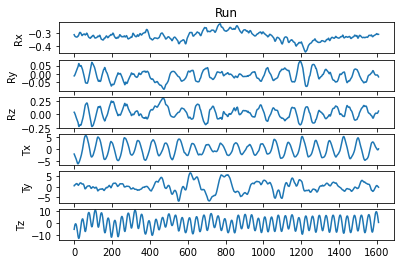

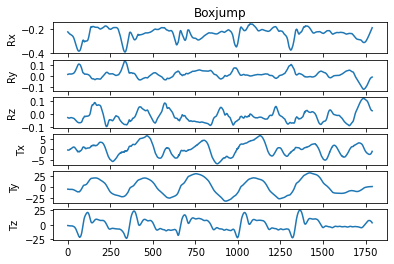

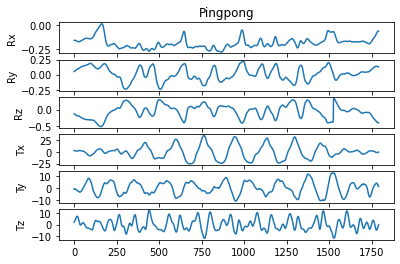

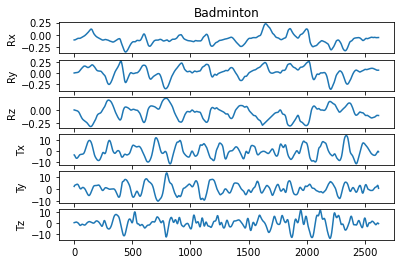

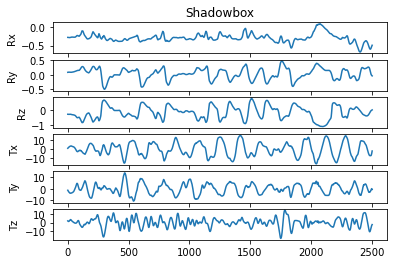

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import time
import serial
from src.stewart_controller import Stewart_Platform

def loadMovement(filepath):
        file = open(filepath)
        csvreader = csv.reader(file)

        rows = []
        for row in csvreader:
                rows.append(row)
        rows

        file.close()

        movements = np.array(rows).astype('float')
        movements[:,0:3] = movements[:,0:3]/180*np.pi /2
        movements[:,3:6] = movements[:,3:6] /2
        return movements

def setupSerial(COM, BAUD):
    # Initialize serial
    ser = serial.Serial()
    ser.port = COM
    ser.baudrate = BAUD
    ser.setDTR(False)
    ser.setRTS(False)
    # ser.close()

    if not ser.isOpen():
        ser.open()
        
    return ser

exercise = list([
        loadMovement('motion_capture\Run_r.csv')*1.2,
        loadMovement('motion_capture\Boxjump2_r.csv')*0.6,
        loadMovement('motion_capture\pingpong_r.csv')*1,
        loadMovement('motion_capture\Badminton_r2.csv')*0.8,
        loadMovement('motion_capture\Shadowbox_r.csv')*1
])

exercise_names = list([
        'Run',
        'Boxjump',
        'Pingpong',
        'Badminton',
        'Shadowbox'
])

labels = list(['Rx', 'Ry', 'Rz', 'Tx', 'Ty', 'Tz'])

for exercise_index in range(5):
        movements = exercise[exercise_index]
        plt.figure(exercise_index)
        
        for i in range(6):
                plt.subplot(611+i)
                if(i == 0):
                        plt.title(exercise_names[exercise_index])
                plt.plot(movements[:,i]) 
                plt.ylabel(labels[i])



We can then iteratively plug in translation and rotations from each timestep to simulate the motion. Total time taken is printed to ensure that there is little deviation from the real samples. 

In [2]:
ser = setupSerial('COM5', 38400)

# Call object, Stewart_Platform(r_B, r_P, lhl, ldl, Psi_B, P si_P, offset_angle)
# offset_angle of 5pi/6 is used to align the y-axis in a way that is aesthetic.

platform = Stewart_Platform(132/2, 175/2, 50.8, 130, 0.2269, 0.82, 5*np.pi/6)

# Initialize Plots
controller_freq = 50
record_freq = 100

%matplotlib qt
fig, ax = plt.subplots()    

for exercise_index in range(5):
    tic = time.time()
    movements = exercise[exercise_index]
    # Loop through positions
    for ix in range(0, np.shape(movements)[0], round(record_freq/controller_freq)):
        time.sleep(0.015)
        servo_angles = platform.calculate(
            np.array([movements[ix,3],movements[ix,4],movements[ix,5]-5]), # Z axis offset by 10 (platform operates better lower)
            np.array([movements[ix,0]-np.pi/36, movements[ix,1], movements[ix,2]])  # X rotation offset by 10 degs (3D printed torso leans backwards at rest)
            )/np.pi*180 # Convert to degrees

        # Send serial data to ESP32 in the form of a string "<A,float,float,float,float,float,float>"
        towrite = np.array2string(servo_angles, precision=1, separator=',').strip('[]')
        towrite = '<A,' + towrite + '>'
        ser.write(towrite.encode())     # write a string
        # print(towrite)

        # # Hide this plotting section if your computer takes too long to plot, affecting the controller speed
        # VIEW = [[10, 76], [20, 90], [50, 50],[30, 90]]
        # view_index = 0
        # ax = platform.plot_platform()
        # ax.view_init(elev=VIEW[view_index][0], azim=VIEW[view_index][1]) # Suitable angle
        
        # plt.title(exercise_names[exercise_index])
        
        # plt.draw()
        # # plt.pause(1/controller_freq/2)
        # plt.pause(0.00001)

    toc = time.time()
    print('Time taken for' + str(exercise_index) + str(tic-toc)) # Measure time to see if plotting affects speed of controller.
    
ser.close()


d:\Github\MCU_App\Stewart_Platform_Motion_Simulator\src\stewart_controller.py:134: RuntimeWarning: invalid value encountered in arcsin
  s.angles[k] = np.arcsin(g[k] / np.sqrt(e[k]**2 + fk**2)) - np.arctan2(fk,e[k])


Time taken for0-18.60857605934143
Time taken for1-19.500512838363647


That's all. Congratulations for completing this tutorial. Please leave a star if you've found this useful. Best of luck to your projects!


Special thanks to:
- My friend and research team supervisor Dr Frances Wan who has helped me operate and understand the Vicon motion capture software.

- Dr Yick who allowed me to take inspiration from her motion simulation research projects and her team who has discussed this topic with extensively

- PolyU's Electronic and Information Engineering Department for hosting the annual Microcontroller Application Competition, of has provided the funds to this project

<A,19.6,19.6,19.6,19.6,19.6,19.6>


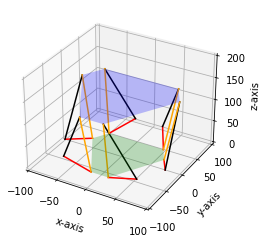

In [ ]:
# Static position for testing purposes

import numpy as np
import matplotlib.pyplot as plt
import serial
from src.stewart_controller import Stewart_Platform

ser = serial.Serial()
ser.port = 'COM5'
ser.baudrate = 38400
ser.setDTR(False)
ser.setRTS(False)

if not ser.isOpen():
    ser.open()

platform = Stewart_Platform(132/2, 175/2, 50.8, 130, 0.2269, 0.82, 5*np.pi/6)
servo_angles = platform.calculate(np.array([0,0,0]), np.array([0, 0,0]) )/np.pi*180

# Send serial data to ESP32 in the form of a string "<A,float,float,float,float,float,float>"
towrite = np.array2string(servo_angles, precision=1, separator=',').strip('[]')
towrite = '<A,' + towrite + '>'
ser.write(towrite.encode())     # write a string
print(towrite)
ax = platform.plot_platform()
plt.draw()


ser.close()
